# OHCL - Analytics

### Import Library

In [179]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns
import math

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [180]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [181]:
data = dataset.copy()

In [182]:
data["ma_line"] = data["Close"].rolling(20).mean()
data['above_ma'] = data.apply(lambda r: 1 if r['Close'] > r['ma_line'] else 0, axis=1)
data['below_ma'] = data.apply(lambda r: 1 if r['Close'] < r['ma_line'] else 0, axis=1)
data['total_above_ma'] = data['above_ma'].rolling(150).sum()
data['total_below_ma'] = data['below_ma'].rolling(150).sum()
data['trend_diff'] = data['total_above_ma'] - data['total_below_ma']
data['ibs'] = data.apply(
    lambda r: 0 if (r['High'] == r['Low']) else abs(r['Close'] - r['Low']) / (r['High'] - r['Low']), axis=1)

In [183]:
def bar9h(tick):
    tick=tick[(tick.index.hour == 9) & (tick.index.minute == 0)]
    if len(tick):
        return tick[0]
def bar14h(tick):
    tick=tick[(tick.index.hour == 14) & (tick.index.minute == 0)]
    if len(tick):
        return tick[0]
# def cal_high(tick):
#     tick=tick[100* tick.index.hour + tick.index.minute >= 1040]
#     if len(tick):
#         return tick.max()
# def cal_low(tick):
#     tick=tick[100* tick.index.hour + tick.index.minute >= 1040]
#     if len(tick):
#         return tick.min()
data['Close_9h'] = data['Close']
data['Close_14h'] = data['Close']
data["RSI"] = ta.rsi(data["Close"], length=14)
day_data = data.resample('D').agg({
        'Open': 'first',
        'Close': 'last',
        'High': 'max',
        'Low': 'min',
        'Close_9h': bar9h,
        'Close_14h': bar14h,
        'RSI': bar915h,
        'trend_diff': bar915h,
        'ibs': bar915h
    })
day_data.dropna(subset=['Close'], inplace=True)

In [184]:
# 1 means first_bar in high area, 2 means first_bar in low area, else 0
def get_first_bar_group(r):
    if r['Close_9h'] > r['High'] - 3:
        group = 1
    elif r['Close_9h'] < r['Low'] + 3:
        group = 2
    else:
        group = 0
    return group
day_data['first_bar_group'] = day_data.apply(lambda r: get_first_bar_group(r), axis=1)

In [185]:
len(day_data[day_data['first_bar_group'] == 0])

686

In [186]:
len(day_data[day_data['first_bar_group'] == 1])

447

In [187]:
len(day_data[day_data['first_bar_group'] == 2])

357

In [188]:
day_data = day_data[(day_data.Close != day_data.Close_14h) & (day_data.High != day_data.Close_14h) & (day_data.High != day_data.Close)]
day_data['diff_overnight'] = 1000*(day_data.Close_9h - day_data.Close.shift(1)) / day_data.Close.shift(1)
day_data['diff_14h'] = 1000*(day_data.Close_9h - day_data.Close_14h.shift(1)) / day_data.Close_14h.shift(1)
day_data['rate_a'] = (day_data.Close_9h - day_data.Close_14h.shift(1)) / (day_data.High.shift(1) - day_data.Low.shift(1))
day_data['rate_b'] = (day_data.Close_9h - day_data.Open.shift(1)) / day_data.Open.shift(1)
day_data['rate_c'] = (day_data.Close_9h - day_data.Close_9h.shift(1)) / (day_data.High.shift(1) - day_data.Low.shift(1))
day_data['rate_d'] = (day_data.Close_9h - day_data.Close.shift(1)) / (day_data.Close.shift(1) - day_data.Close_14h.shift(1))
day_data['14h_low_high'] = (day_data.Close_14h.shift(1) - day_data.Low.shift(1)) / (day_data.High.shift(1) - day_data.Close_14h.shift(1))
day_data['14h45_low_high'] = (day_data.Close.shift(1) - day_data.Low.shift(1)) / (day_data.High.shift(1) - day_data.Close.shift(1))
day_data['9h_lastclose'] = 1000*(day_data.Close_9h - day_data.Open) / day_data.Close.shift(1)
day_data['9h_last14h'] = 1000*(day_data.Close_9h - day_data.Open) / day_data.Close_14h.shift(1)

In [189]:
day_data.dropna(inplace=True)

In [190]:
group_high = day_data[day_data.first_bar_group==1]
group_low = day_data[day_data.first_bar_group==2]
group_none = day_data[day_data.first_bar_group==0]

In [191]:
day_data

,Open,Close,High,Low,Close_9h,Close_14h,RSI,trend_diff,ibs,first_bar_group,diff_overnight,diff_14h,rate_a,rate_b,rate_c,rate_d,14h_low_high,14h45_low_high,9h_lastclose,9h_last14h
Date,,,,,,,,,,,,,,,,,,,,
2018-08-16,942.4,947.0,947.3,935.5,942.1,944.0,34.797133,14.0,0.166667,0,-4.753856,-16.289026,-0.993631,-0.016597,-1.184713,0.405405,2.413043,0.000000,-0.316924,-0.313250
2018-08-17,952.2,947.0,954.6,945.0,953.2,947.4,49.895873,-8.0,1.000000,1,6.546990,9.745763,0.779661,0.011460,0.940678,2.066667,2.575758,38.333333,1.055966,1.059322
2018-08-20,946.1,945.0,951.5,942.6,946.1,946.4,44.554292,-44.0,0.700000,0,-0.950370,-1.372176,-0.135417,-0.006406,-0.739583,2.250000,0.333333,0.263158,0.000000,0.000000
2018-08-22,959.5,957.0,960.6,953.6,959.5,957.8,61.217958,40.0,0.500000,1,15.343915,13.841927,1.471910,0.014163,1.505618,-10.357143,0.745098,0.369231,0.000000,0.000000
2018-08-23,957.0,960.6,963.5,955.8,956.9,962.5,55.356606,48.0,0.800000,2,-0.104493,-0.939653,-0.128571,-0.002710,-0.371429,0.125000,1.500000,0.944444,-0.104493,-0.104406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-24,1283.3,1283.5,1287.4,1273.3,1284.0,1281.0,35.838821,-60.0,0.925926,0,-0.155739,-9.259259,-0.508475,-0.013446,-0.817797,0.016949,2.064935,0.210256,0.545086,0.540123
2024-07-25,1276.9,1276.6,1278.9,1270.7,1273.7,1273.2,40.049018,-38.0,0.928571,0,-7.635372,-5.698673,-0.517730,-0.007481,-0.730496,-3.920000,1.203125,2.615385,-2.493183,-2.498048
2024-07-29,1289.9,1287.8,1294.7,1287.8,1291.4,1292.9,63.562403,50.0,0.166667,0,11.593295,14.294691,2.219512,0.011356,2.158537,4.352941,0.438596,2.565217,1.174996,1.178134


In [192]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [193]:
data_train = day_data[day_data.index < '2024-01-01 00:00:00']
data_test = day_data[day_data.index > '2024-01-01 00:00:00']

In [194]:
feature_cols = ['9h_lastclose', 'diff_overnight', 'diff_14h', '14h_low_high', '14h45_low_high']
# Splitting 
X_train = data_train[feature_cols]
y_train = data_train[['first_bar_group']]
X_test = data_test[feature_cols]
y_test = data_test[['first_bar_group']]

In [195]:
%%time

parameters = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05],
    'max_depth': [8],
    'gamma': [0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_test, y_test)]
# Create XGBClassifier model
model_xgb = xgb.XGBClassifier(eval_set=eval_set, objective='reg:logistic', verbose=False)
clf = GridSearchCV(model_xgb, parameters)

clf.fit(X_train, y_train)

CPU times: user 1min 23s, sys: 1.17 s, total: 1min 24s
Wall time: 14.2 s


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     eval_set=[(            9h_lastclose  diff_overnight   diff_14h  14h_low_high  \
Date                                                                
2018-08-16     -0.316924       -4.753856 -16.289026      2.413043   
2018-08-17      1.0...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'gamma': [0.01, 0.02], 'learning_rate': [0.01, 0.05],
                         'max_depth': [8], 'n_estimators': [100, 150, 200],
                         'random_state': [42]})

In [196]:
print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.01, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 100, 'random_state': 42}
Best validation score = 0.5085726862550897


In [197]:
best_model = xgb.XGBClassifier(**clf.best_params_, objective='reg:squarederror')
best_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.01, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

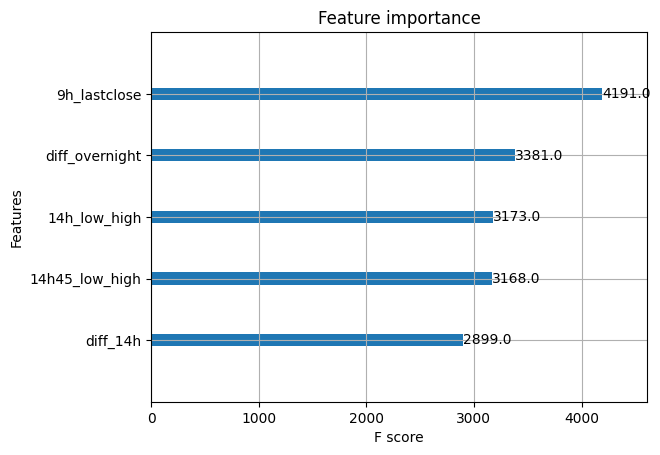

In [198]:
plot_importance(best_model)

In [199]:
y_pred = best_model.predict(X_test)

In [200]:
from sklearn.metrics import mean_squared_error
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 0.9126984126984127


In [201]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("R2_score:", metrics.r2_score(y_test, y_pred))

Accuracy: 0.4444444444444444
R2_score: -0.4797794117647065


In [202]:
X_result = X_test.copy()
X_result = X_result.assign(Predicts=y_pred)
X_result = X_result[['Predicts']]
data_result = data_test.copy()
data_result = pd.merge(data_result, X_result, left_index=True, right_index=True, how="left")
data_result.dropna(inplace=True)
data_result

,Open,Close,High,Low,Close_9h,Close_14h,RSI,trend_diff,ibs,first_bar_group,...,diff_14h,rate_a,rate_b,rate_c,rate_d,14h_low_high,14h45_low_high,9h_lastclose,9h_last14h,Predicts
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-02,1138.5,1133.5,1141.8,1131.0,1140.8,1133.7,44.266893,58.0,0.777778,1,...,7.862885,1.034884,0.006707,0.732558,2.296296,0.131579,0.755102,2.027146,2.031982,0
2024-01-04,1146.0,1156.5,1171.0,1145.5,1147.4,1168.2,69.607355,33.0,0.000000,2,...,12.084326,1.268519,0.007817,0.611111,-69.500000,0.333333,0.301205,1.235112,1.234895,1
2024-01-08,1166.1,1162.0,1173.3,1160.6,1171.5,1165.5,56.745471,74.0,1.000000,1,...,2.824859,0.129412,0.022251,0.945098,-1.282051,8.107143,0.758621,4.669261,4.622496,0
2024-01-09,1166.0,1163.0,1166.0,1159.0,1164.4,1161.7,52.202134,-6.0,0.333333,1,...,-0.943801,-0.086614,-0.001458,-0.559055,-0.685714,0.628205,0.123894,-1.376936,-1.372801,1
2024-01-10,1162.5,1163.1,1170.8,1159.7,1163.3,1166.3,77.098297,-16.0,0.806452,0,...,1.377292,0.228571,-0.002316,-0.157143,0.230769,0.627907,1.333333,0.687876,0.688646,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-24,1283.3,1283.5,1287.4,1273.3,1284.0,1281.0,35.838821,-60.0,0.925926,0,...,-9.259259,-0.508475,-0.013446,-0.817797,0.016949,2.064935,0.210256,0.545086,0.540123,0
2024-07-25,1276.9,1276.6,1278.9,1270.7,1273.7,1273.2,40.049018,-38.0,0.928571,0,...,-5.698673,-0.517730,-0.007481,-0.730496,-3.920000,1.203125,2.615385,-2.493183,-2.498048,0
2024-07-29,1289.9,1287.8,1294.7,1287.8,1291.4,1292.9,63.562403,50.0,0.166667,0,...,14.294691,2.219512,0.011356,2.158537,4.352941,0.438596,2.565217,1.174996,1.178134,0


### Wrong data

In [203]:
data_result[data_result.Predicts != data_result.first_bar_group]

,Open,Close,High,Low,Close_9h,Close_14h,RSI,trend_diff,ibs,first_bar_group,...,diff_14h,rate_a,rate_b,rate_c,rate_d,14h_low_high,14h45_low_high,9h_lastclose,9h_last14h,Predicts
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-02,1138.5,1133.5,1141.8,1131.0,1140.8,1133.7,44.266893,58.0,0.777778,1,...,7.862885,1.034884,0.006707,0.732558,2.296296,0.131579,0.755102,2.027146,2.031982,0
2024-01-04,1146.0,1156.5,1171.0,1145.5,1147.4,1168.2,69.607355,33.0,0.000000,2,...,12.084326,1.268519,0.007817,0.611111,-69.500000,0.333333,0.301205,1.235112,1.234895,1
2024-01-08,1166.1,1162.0,1173.3,1160.6,1171.5,1165.5,56.745471,74.0,1.000000,1,...,2.824859,0.129412,0.022251,0.945098,-1.282051,8.107143,0.758621,4.669261,4.622496,0
2024-01-10,1162.5,1163.1,1170.8,1159.7,1163.3,1166.3,77.098297,-16.0,0.806452,0,...,1.377292,0.228571,-0.002316,-0.157143,0.230769,0.627907,1.333333,0.687876,0.688646,1
2024-01-11,1164.8,1168.1,1176.2,1162.9,1165.5,1166.6,67.535529,-8.0,1.000000,2,...,-0.685930,-0.072072,0.002581,0.198198,-0.750000,1.466667,0.441558,0.601840,0.600189,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-16,1301.5,1302.7,1308.7,1299.1,1301.6,1303.1,70.961895,-36.0,0.695652,2,...,2.155836,0.217054,-0.000307,-0.139535,13.000000,0.897059,0.954545,0.076982,0.076994,1
2024-07-17,1309.0,1303.2,1321.8,1294.7,1308.5,1318.0,39.267558,-22.0,0.700000,0,...,4.143964,0.562500,0.005378,0.718750,-14.500000,0.714286,0.600000,-0.383818,-0.383700,1
2024-07-18,1303.1,1297.5,1305.0,1287.9,1303.1,1291.3,45.953228,-10.0,0.588235,1,...,-11.305008,-0.549815,-0.004507,-0.199262,0.006757,6.131579,0.456989,0.000000,0.000000,0


In [205]:
data_result[(data_result.Predicts != data_result.first_bar_group) & (data_result.Predicts == 1) & (data_result.Close_9h > data_result.Close)]

,Open,Close,High,Low,Close_9h,Close_14h,RSI,trend_diff,ibs,first_bar_group,...,diff_14h,rate_a,rate_b,rate_c,rate_d,14h_low_high,14h45_low_high,9h_lastclose,9h_last14h,Predicts
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-10,1162.5,1163.1,1170.8,1159.7,1163.3,1166.3,77.098297,-16.0,0.806452,0,...,1.377292,0.228571,-0.002316,-0.157143,0.230769,0.627907,1.333333,0.687876,0.688646,1
2024-01-17,1171.2,1166.0,1179.6,1164.4,1170.2,1168.5,68.676564,50.0,0.090909,0,...,-0.170882,-0.015873,0.001112,-0.380952,-0.974026,1.571429,0.000000,-0.860067,-0.854409,1
2024-01-24,1183.4,1180.7,1190.4,1179.1,1184.5,1184.8,37.058945,-27.0,0.444444,0,...,2.030285,0.186047,-0.007125,-0.759690,0.263158,0.040323,0.228571,0.929054,0.930547,1
2024-02-23,1240.5,1225.1,1253.9,1225.1,1241.4,1242.8,71.206493,-4.0,0.866667,0,...,2.908386,0.545455,0.001048,0.106061,17.000000,0.404255,0.466667,0.726979,0.727096,1
2024-04-01,1293.0,1290.4,1299.4,1283.2,1292.2,1289.3,34.098337,22.0,0.000000,0,...,-6.993007,-0.758333,-0.010718,-0.908333,1.843750,1.000000,0.304348,-0.616285,-0.614770,1
2024-04-05,1254.0,1252.1,1264.8,1252.0,1256.5,1261.2,38.020556,-36.0,0.687500,0,...,-11.097119,-0.921569,-0.015205,-1.424837,1.517857,0.577320,0.000000,1.976285,1.967574,1
2024-04-10,1265.0,1260.1,1272.9,1259.3,1268.5,1265.3,61.895079,48.0,0.125000,0,...,6.266857,0.782178,0.008748,1.059406,1.194444,1.729730,100.000000,2.768549,2.776456,1
2024-04-16,1234.9,1230.0,1237.8,1213.0,1232.5,1218.0,26.683713,0.0,0.000000,0,...,-31.358064,-0.736162,-0.038236,-0.843173,0.105263,2.763889,0.073267,-1.941276,-1.886199,1
2024-05-10,1274.2,1270.4,1280.3,1259.0,1274.9,1263.8,47.054475,26.0,0.545455,0,...,-1.331662,-0.114865,-0.001644,-0.385135,-0.776316,1.792453,0.147287,0.551615,0.548332,1


In [206]:
data_result[(data_result.Predicts != data_result.first_bar_group) & (data_result.Predicts == 2) & (data_result.Close_9h < data_result.Close)]

,Open,Close,High,Low,Close_9h,Close_14h,RSI,trend_diff,ibs,first_bar_group,...,diff_14h,rate_a,rate_b,rate_c,rate_d,14h_low_high,14h45_low_high,9h_lastclose,9h_last14h,Predicts
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-01,1265.0,1266.8,1268.7,1259.1,1263.2,1261.1,55.270241,30.0,1.000000,0,...,4.692595,0.366460,-0.002369,-0.378882,0.072727,0.141844,0.872093,-1.425404,-1.431639,2
2024-04-09,1257.5,1264.2,1264.3,1254.2,1257.8,1260.6,50.736253,-28.0,1.000000,0,...,1.672374,0.172131,0.001353,0.229508,-2.400000,2.297297,1.346154,0.239196,0.238911,2
2024-07-01,1277.7,1285.0,1285.8,1271.7,1275.4,1279.0,45.846123,-38.0,0.416667,0,...,-7.316314,-0.463054,-0.012237,-0.817734,-0.104762,1.537500,0.097297,-1.804913,-1.790162,2
2024-07-04,1307.0,1308.6,1313.3,1303.5,1307.6,1308.5,51.571425,102.0,0.625000,0,...,-0.611434,-0.053333,0.008095,0.693333,-0.428571,12.636364,5.000000,0.459067,0.458575,2


In [207]:
# predict shorts
data_result[(data_result.Predicts == 1) & (data_result.High > data_result.Close_9h + 5)]

,Open,Close,High,Low,Close_9h,Close_14h,RSI,trend_diff,ibs,first_bar_group,...,diff_14h,rate_a,rate_b,rate_c,rate_d,14h_low_high,14h45_low_high,9h_lastclose,9h_last14h,Predicts
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-04,1146.0,1156.5,1171.0,1145.5,1147.4,1168.2,69.607355,33.0,0.000000,2,...,12.084326,1.268519,0.007817,0.611111,-69.500000,0.333333,0.301205,1.235112,1.234895,1
2024-01-10,1162.5,1163.1,1170.8,1159.7,1163.3,1166.3,77.098297,-16.0,0.806452,0,...,1.377292,0.228571,-0.002316,-0.157143,0.230769,0.627907,1.333333,0.687876,0.688646,1
2024-01-11,1164.8,1168.1,1176.2,1162.9,1165.5,1166.6,67.535529,-8.0,1.000000,2,...,-0.685930,-0.072072,0.002581,0.198198,-0.750000,1.466667,0.441558,0.601840,0.600189,1
2024-01-17,1171.2,1166.0,1179.6,1164.4,1170.2,1168.5,68.676564,50.0,0.090909,0,...,-0.170882,-0.015873,0.001112,-0.380952,-0.974026,1.571429,0.000000,-0.860067,-0.854409,1
2024-01-18,1168.1,1172.8,1177.8,1165.8,1169.0,1176.0,39.527648,18.0,0.173913,0,...,0.427899,0.032895,-0.001878,-0.078947,-1.200000,0.369369,0.117647,0.771870,0.770218,1
2024-01-24,1183.4,1180.7,1190.4,1179.1,1184.5,1184.8,37.058945,-27.0,0.444444,0,...,2.030285,0.186047,-0.007125,-0.759690,0.263158,0.040323,0.228571,0.929054,0.930547,1
2024-02-05,1182.6,1202.5,1211.0,1181.3,1181.9,1206.0,71.389578,22.0,1.000000,2,...,2.714855,0.432432,0.002035,0.000000,0.333333,1.055556,5.166667,-0.592668,-0.593875,1
2024-02-07,1206.7,1219.0,1219.8,1205.3,1206.9,1217.5,58.881166,65.0,0.857143,2,...,3.075133,0.740000,0.004327,0.400000,4.285714,0.923077,1.631579,0.166127,0.166223,1
2024-02-23,1240.5,1225.1,1253.9,1225.1,1241.4,1242.8,71.206493,-4.0,0.866667,0,...,2.908386,0.545455,0.001048,0.106061,17.000000,0.404255,0.466667,0.726979,0.727096,1
